## Тестовое задание для VKLab

Список литературы:
    1. https://arxiv.org/pdf/1503.02531.pdf
    2. https://arxiv.org/pdf/2004.05937v3.pdf

Зависимости:
    1. https://github.com/pabloppp/pytorch-tools

### Постановка задачи

Целью этого тестового задания я ставлю разобраться с методом Knowledge Distillation (KD) и самостоятельно протестировать его на практике. 

### Подготовительные процедуры

In [1]:
import numpy as np
import torch.nn as nn
import torch
import torchvision
import random

In [2]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.data import RandomSampler, SequentialSampler
from torchvision import datasets, models, transforms
from torchtools.optim import Ralamb
import os

In [3]:
# обеспечим воспроизводимость результатов

def set_seed(seed = 1234):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Определим модель-учителя

Я сфокусируюсь на моделях компьютерного зрения, взяв в качестве датасета предложенный организаторами imagewoof, а в качестве модели-учителя - pretrained ResNet50.

In [5]:
num_classes = 10
batch_size = 128

In [8]:
def initialize_model(num_classes):
    model = models.resnet50(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False
    
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224
    
    return model, input_size

In [6]:
model_teacher, input_size = initialize_model(num_classes)

In [7]:
from torchtools.optim import Ranger

model_teacher = model_teacher.to(device)

teacher_params = []
for name, param in model_teacher.named_parameters():
    if param.requires_grad == True:
        teacher_params.append(param)

optimizer_teacher = Ranger(teacher_params, lr=0.001)

### Подготовка данных

In [56]:
data_dir = 'imagewoof2-320/'

In [59]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [60]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=8) for x in ['train', 'val', 'test']}

### Функция для обучения

Я попытаюсь продемонстрировать простейший способ Knowledge Distillation, предложенный Hinton et al. 
А именно, при обучении модели-ученика, будем использовать Loss-функцию, учитывающую предсказания модели-учителя:

$$ L(x,W)=\alpha H(y, \sigma (z_s; T=1)+ \beta  H(\sigma(z_t;T =\tau),\sigma(z_s,T = \tau)) $$

где x это входные данные, W - параметры модели-ученика, H - функция потерь (например, кросс-энтропия), y - метки классов, $\sigma$ - функция Softmax, параметризаванная температурой T, $\alpha$ and $\beta$ - коэффиценты, $z_s$ and $z_t$ - logits студента и ученика.

У меня $$\beta = 1 - \alpha$$

In [208]:
def studentLossFn(teacher_pred, student_pred, y, T, alpha):
    if (alpha > 0):
        loss = F.kl_div(F.log_softmax(student_pred / T, dim=1), F.softmax(teacher_pred / T, dim=1), reduction='batchmean') * (T ** 2) * alpha + F.cross_entropy(student_pred, y) * (1 - alpha)
    else:
        loss = F.cross_entropy(student_pred, y)
    return loss

In [ ]:
def train(model_type, model, dataloaders, criterion, optimizer, num_epochs, teacher_model=None):
    since = time.time()
    
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0.0
            
            # iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    if model_type == 'teacher' or model_type == 'student_solo':
                        loss = criterion(outputs, labels)
                    elif model_type == 'student':
                        teacher_pred = teacher_model(inputs)
                        loss = studentLossFn(teacher_pred, outputs, labels, T=10, alpha=0.1)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    # backprop
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), model_type + 'saved_weights_v1_'+ 'e_' + str(epoch) + '.pt')
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        
        print()
        
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

### Обучение модели-учителя

Проведем fine-tuning модели ResNet50 для задачи классификации пород собак (датасет - imagewoof).

In [ ]:
import time
import copy

In [ ]:
num_epochs_teacher = 20

In [ ]:
# Setup the loss fxn
criterion_teacher = nn.CrossEntropyLoss()

# Train and evaluate
best_teacher, teacher_hist = train('teacher', 
                                   model_teacher, 
                                   dataloaders_dict, 
                                   criterion_teacher, 
                                   optimizer_teacher, 
                                   num_epochs_teacher,
                                   None)

### Обучение модели ученика

В качетсве модели-ученика возьмем небольшую CNN.

In [42]:
import torch.nn.functional as F

In [43]:
class StudentNetwork(nn.Module):
    def __init__(self):
        super(StudentNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [45]:
model_student = StudentNetwork()
model_student = model_student.to(device)

optimizer_student = Ranger(model_student.parameters(), lr=0.001)

In [48]:
best_student, student_hist = train('student', 
                                           model_student, 
                                           dataloaders_dict, 
                                           criterion,
                                           optimizer_student, 
                                           num_epochs=500, 
                                           teacher_model=model_teacher)

Epoch 0/499
----------
train Loss: 6.5415 Acc: 0.1192
val Loss: 7.9108 Acc: 0.1693

Epoch 1/499
----------
train Loss: 6.0206 Acc: 0.1876
val Loss: 7.4636 Acc: 0.2220

Epoch 2/499
----------
train Loss: 5.8711 Acc: 0.2153
val Loss: 7.2188 Acc: 0.2599

Epoch 3/499
----------
train Loss: 5.8433 Acc: 0.2220
val Loss: 7.1405 Acc: 0.2829

Epoch 4/499
----------
train Loss: 5.7794 Acc: 0.2418
val Loss: 7.0343 Acc: 0.2761

Epoch 5/499
----------
train Loss: 5.6960 Acc: 0.2469
val Loss: 7.0008 Acc: 0.2964

Epoch 6/499
----------
train Loss: 5.5849 Acc: 0.2550
val Loss: 6.8859 Acc: 0.2827

Epoch 7/499
----------
train Loss: 5.5366 Acc: 0.2652
val Loss: 6.8529 Acc: 0.3085

Epoch 8/499
----------
train Loss: 5.4877 Acc: 0.2770
val Loss: 6.7107 Acc: 0.3233

Epoch 9/499
----------
train Loss: 5.4119 Acc: 0.2790
val Loss: 6.6158 Acc: 0.3337

Epoch 10/499
----------
train Loss: 5.3792 Acc: 0.2924
val Loss: 6.4950 Acc: 0.3491

Epoch 11/499
----------
train Loss: 5.3618 Acc: 0.2956
val Loss: 6.4739 Acc

val Loss: 5.2164 Acc: 0.4676

Epoch 97/499
----------
train Loss: 3.9614 Acc: 0.4397
val Loss: 5.2253 Acc: 0.4759

Epoch 98/499
----------
train Loss: 4.0661 Acc: 0.4386
val Loss: 5.4163 Acc: 0.4583

Epoch 99/499
----------
train Loss: 3.9963 Acc: 0.4399
val Loss: 5.2126 Acc: 0.4657

Epoch 100/499
----------
train Loss: 4.0318 Acc: 0.4430
val Loss: 5.0812 Acc: 0.4808

Epoch 101/499
----------
train Loss: 4.0279 Acc: 0.4361
val Loss: 5.0866 Acc: 0.4811

Epoch 102/499
----------
train Loss: 3.9502 Acc: 0.4453
val Loss: 5.1862 Acc: 0.4844

Epoch 103/499
----------
train Loss: 3.9623 Acc: 0.4431
val Loss: 5.2714 Acc: 0.4684

Epoch 104/499
----------
train Loss: 3.9746 Acc: 0.4490
val Loss: 5.0521 Acc: 0.4802

Epoch 105/499
----------
train Loss: 4.0538 Acc: 0.4398
val Loss: 5.1809 Acc: 0.4706

Epoch 106/499
----------
train Loss: 3.9896 Acc: 0.4448
val Loss: 5.1297 Acc: 0.4822

Epoch 107/499
----------
train Loss: 4.0098 Acc: 0.4402
val Loss: 5.0746 Acc: 0.4887

Epoch 108/499
----------
tr

train Loss: 3.7268 Acc: 0.4792
val Loss: 4.8218 Acc: 0.5005

Epoch 193/499
----------
train Loss: 3.6462 Acc: 0.4794
val Loss: 4.7986 Acc: 0.5036

Epoch 194/499
----------
train Loss: 3.6539 Acc: 0.4812
val Loss: 4.7597 Acc: 0.5148

Epoch 195/499
----------
train Loss: 3.6510 Acc: 0.4794
val Loss: 4.8693 Acc: 0.5011

Epoch 196/499
----------
train Loss: 3.6146 Acc: 0.4857
val Loss: 4.7199 Acc: 0.5134

Epoch 197/499
----------
train Loss: 3.6244 Acc: 0.4808
val Loss: 4.7492 Acc: 0.5093

Epoch 198/499
----------
train Loss: 3.6285 Acc: 0.4814
val Loss: 4.8041 Acc: 0.5077

Epoch 199/499
----------
train Loss: 3.6534 Acc: 0.4738
val Loss: 4.8031 Acc: 0.5118

Epoch 200/499
----------
train Loss: 3.6649 Acc: 0.4817
val Loss: 4.8168 Acc: 0.5055

Epoch 201/499
----------
train Loss: 3.6382 Acc: 0.4803
val Loss: 4.7445 Acc: 0.5113

Epoch 202/499
----------
train Loss: 3.6087 Acc: 0.4791
val Loss: 4.7304 Acc: 0.5151

Epoch 203/499
----------
train Loss: 3.5856 Acc: 0.4838
val Loss: 4.7107 Acc: 0

val Loss: 4.5143 Acc: 0.5288

Epoch 288/499
----------
train Loss: 3.3992 Acc: 0.5114
val Loss: 4.5655 Acc: 0.5214

Epoch 289/499
----------
train Loss: 3.4373 Acc: 0.5004
val Loss: 4.6635 Acc: 0.5167

Epoch 290/499
----------
train Loss: 3.4128 Acc: 0.5053
val Loss: 4.6364 Acc: 0.5200

Epoch 291/499
----------
train Loss: 3.3823 Acc: 0.5059
val Loss: 4.5413 Acc: 0.5305

Epoch 292/499
----------
train Loss: 3.3788 Acc: 0.5100
val Loss: 4.5951 Acc: 0.5151

Epoch 293/499
----------
train Loss: 3.4220 Acc: 0.5124
val Loss: 4.5084 Acc: 0.5274

Epoch 294/499
----------
train Loss: 3.4095 Acc: 0.5039
val Loss: 4.5344 Acc: 0.5247

Epoch 295/499
----------
train Loss: 3.4397 Acc: 0.5054
val Loss: 4.5714 Acc: 0.5200

Epoch 296/499
----------
train Loss: 3.3986 Acc: 0.5059
val Loss: 4.5417 Acc: 0.5225

Epoch 297/499
----------
train Loss: 3.4017 Acc: 0.5076
val Loss: 4.5708 Acc: 0.5209

Epoch 298/499
----------
train Loss: 3.4199 Acc: 0.5028
val Loss: 4.5583 Acc: 0.5233

Epoch 299/499
----------

train Loss: 3.2799 Acc: 0.5159
val Loss: 4.4319 Acc: 0.5313

Epoch 384/499
----------
train Loss: 3.3031 Acc: 0.5237
val Loss: 4.5649 Acc: 0.5236

Epoch 385/499
----------
train Loss: 3.3212 Acc: 0.5097
val Loss: 4.4334 Acc: 0.5280

Epoch 386/499
----------
train Loss: 3.3199 Acc: 0.5156
val Loss: 4.4957 Acc: 0.5263

Epoch 387/499
----------
train Loss: 3.3014 Acc: 0.5219
val Loss: 4.5095 Acc: 0.5272

Epoch 388/499
----------
train Loss: 3.3054 Acc: 0.5166
val Loss: 4.4682 Acc: 0.5272

Epoch 389/499
----------
train Loss: 3.2925 Acc: 0.5194
val Loss: 4.4515 Acc: 0.5321

Epoch 390/499
----------
train Loss: 3.2712 Acc: 0.5224
val Loss: 4.5335 Acc: 0.5198

Epoch 391/499
----------
train Loss: 3.3114 Acc: 0.5167
val Loss: 4.5610 Acc: 0.5244

Epoch 392/499
----------
train Loss: 3.3060 Acc: 0.5116
val Loss: 4.4656 Acc: 0.5247

Epoch 393/499
----------
train Loss: 3.2502 Acc: 0.5296
val Loss: 4.5340 Acc: 0.5255

Epoch 394/499
----------
train Loss: 3.2758 Acc: 0.5141
val Loss: 4.4583 Acc: 0

val Loss: 4.3172 Acc: 0.5387

Epoch 479/499
----------
train Loss: 3.2157 Acc: 0.5260
val Loss: 4.3145 Acc: 0.5384

Epoch 480/499
----------
train Loss: 3.2132 Acc: 0.5292
val Loss: 4.3801 Acc: 0.5340

Epoch 481/499
----------
train Loss: 3.1834 Acc: 0.5317
val Loss: 4.4497 Acc: 0.5294

Epoch 482/499
----------
train Loss: 3.2244 Acc: 0.5248
val Loss: 4.4267 Acc: 0.5294

Epoch 483/499
----------
train Loss: 3.1990 Acc: 0.5271
val Loss: 4.4558 Acc: 0.5192

Epoch 484/499
----------
train Loss: 3.1791 Acc: 0.5272
val Loss: 4.3442 Acc: 0.5296

Epoch 485/499
----------
train Loss: 3.1814 Acc: 0.5295
val Loss: 4.3375 Acc: 0.5398

Epoch 486/499
----------
train Loss: 3.1293 Acc: 0.5355
val Loss: 4.3402 Acc: 0.5398

Epoch 487/499
----------
train Loss: 3.1878 Acc: 0.5324
val Loss: 4.3739 Acc: 0.5338

Epoch 488/499
----------
train Loss: 3.2130 Acc: 0.5293
val Loss: 4.3847 Acc: 0.5373

Epoch 489/499
----------
train Loss: 3.1385 Acc: 0.5329
val Loss: 4.3021 Acc: 0.5420

Epoch 490/499
----------

### Маленькая модель в соло(без учителя)

In [31]:
student_net_solo = StudentNetwork()
student_net_solo = student_net_solo.to(device)

optimizer_student_solo = Ranger(student_net_solo.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [37]:
best_student_solo, solo_hist = train_solo('student_solo_', 
                                                          student_net_solo, 
                                                          dataloaders_dict, 
                                                          criterion, 
                                                          optimizer_student_solo, 
                                                          num_epochs=500,
                                                          None)

Epoch 0/499
----------
train Loss: 2.1964 Acc: 0.1869
val Loss: 2.1070 Acc: 0.2239

Epoch 1/499
----------
train Loss: 2.1398 Acc: 0.2202
val Loss: 2.0497 Acc: 0.2599

Epoch 2/499
----------
train Loss: 2.1119 Acc: 0.2308
val Loss: 2.0360 Acc: 0.2596

Epoch 3/499
----------
train Loss: 2.0967 Acc: 0.2412
val Loss: 2.0281 Acc: 0.2623

Epoch 4/499
----------
train Loss: 2.0824 Acc: 0.2430
val Loss: 1.9839 Acc: 0.2950

Epoch 5/499
----------
train Loss: 2.0685 Acc: 0.2520
val Loss: 1.9658 Acc: 0.3087

Epoch 6/499
----------
train Loss: 2.0459 Acc: 0.2568
val Loss: 2.0124 Acc: 0.2840

Epoch 7/499
----------
train Loss: 2.0459 Acc: 0.2529
val Loss: 2.0237 Acc: 0.2799

Epoch 8/499
----------
train Loss: 2.0399 Acc: 0.2659
val Loss: 1.9596 Acc: 0.3010

Epoch 9/499
----------
train Loss: 2.0141 Acc: 0.2757
val Loss: 1.9139 Acc: 0.3164

Epoch 10/499
----------
train Loss: 2.0179 Acc: 0.2688
val Loss: 1.9148 Acc: 0.3312

Epoch 11/499
----------
train Loss: 1.9986 Acc: 0.2853
val Loss: 1.9083 Acc

val Loss: 1.5939 Acc: 0.4536

Epoch 97/499
----------
train Loss: 1.5300 Acc: 0.4743
val Loss: 1.6177 Acc: 0.4523

Epoch 98/499
----------
train Loss: 1.5541 Acc: 0.4567
val Loss: 1.5015 Acc: 0.4756

Epoch 99/499
----------
train Loss: 1.5439 Acc: 0.4613
val Loss: 1.5193 Acc: 0.4794

Epoch 100/499
----------
train Loss: 1.5354 Acc: 0.4699
val Loss: 1.4938 Acc: 0.4857

Epoch 101/499
----------
train Loss: 1.5353 Acc: 0.4700
val Loss: 1.4793 Acc: 0.4931

Epoch 102/499
----------
train Loss: 1.5302 Acc: 0.4688
val Loss: 1.5161 Acc: 0.4920

Epoch 103/499
----------
train Loss: 1.5517 Acc: 0.4637
val Loss: 1.5542 Acc: 0.4723

Epoch 104/499
----------
train Loss: 1.5120 Acc: 0.4751
val Loss: 1.4826 Acc: 0.4940

Epoch 105/499
----------
train Loss: 1.5073 Acc: 0.4790
val Loss: 1.5216 Acc: 0.4778

Epoch 106/499
----------
train Loss: 1.5023 Acc: 0.4759
val Loss: 1.4736 Acc: 0.4909

Epoch 107/499
----------
train Loss: 1.5177 Acc: 0.4737
val Loss: 1.4799 Acc: 0.4948

Epoch 108/499
----------
tr

train Loss: 1.4321 Acc: 0.5024
val Loss: 1.4534 Acc: 0.5000

Epoch 193/499
----------
train Loss: 1.4215 Acc: 0.5069
val Loss: 1.4903 Acc: 0.4882

Epoch 194/499
----------
train Loss: 1.4157 Acc: 0.5107
val Loss: 1.4654 Acc: 0.5014

Epoch 195/499
----------
train Loss: 1.4106 Acc: 0.5130
val Loss: 1.4513 Acc: 0.5069

Epoch 196/499
----------
train Loss: 1.4280 Acc: 0.5027
val Loss: 1.4424 Acc: 0.5027

Epoch 197/499
----------
train Loss: 1.4119 Acc: 0.5118
val Loss: 1.4247 Acc: 0.5115

Epoch 198/499
----------
train Loss: 1.3847 Acc: 0.5181
val Loss: 1.4824 Acc: 0.4975

Epoch 199/499
----------
train Loss: 1.3908 Acc: 0.5199
val Loss: 1.4561 Acc: 0.5074

Epoch 200/499
----------
train Loss: 1.4097 Acc: 0.5122
val Loss: 1.5258 Acc: 0.4871

Epoch 201/499
----------
train Loss: 1.3919 Acc: 0.5121
val Loss: 1.4516 Acc: 0.5110

Epoch 202/499
----------
train Loss: 1.3840 Acc: 0.5249
val Loss: 1.4380 Acc: 0.5140

Epoch 203/499
----------
train Loss: 1.4168 Acc: 0.5132
val Loss: 1.4379 Acc: 0

val Loss: 1.4166 Acc: 0.5228

Epoch 288/499
----------
train Loss: 1.3604 Acc: 0.5258
val Loss: 1.4703 Acc: 0.5060

Epoch 289/499
----------
train Loss: 1.3540 Acc: 0.5343
val Loss: 1.4587 Acc: 0.5058

Epoch 290/499
----------
train Loss: 1.3268 Acc: 0.5391
val Loss: 1.4467 Acc: 0.5148

Epoch 291/499
----------
train Loss: 1.3641 Acc: 0.5319
val Loss: 1.4417 Acc: 0.5143

Epoch 292/499
----------
train Loss: 1.3559 Acc: 0.5323
val Loss: 1.4479 Acc: 0.5110

Epoch 293/499
----------
train Loss: 1.3224 Acc: 0.5460
val Loss: 1.4183 Acc: 0.5241

Epoch 294/499
----------
train Loss: 1.3326 Acc: 0.5436
val Loss: 1.4205 Acc: 0.5214

Epoch 295/499
----------
train Loss: 1.3518 Acc: 0.5282
val Loss: 1.5415 Acc: 0.4739

Epoch 296/499
----------
train Loss: 1.3625 Acc: 0.5311
val Loss: 1.4932 Acc: 0.5060

Epoch 297/499
----------
train Loss: 1.3461 Acc: 0.5405
val Loss: 1.4323 Acc: 0.5137

Epoch 298/499
----------
train Loss: 1.3419 Acc: 0.5336
val Loss: 1.4679 Acc: 0.5123

Epoch 299/499
----------

train Loss: 1.3089 Acc: 0.5495
val Loss: 1.4065 Acc: 0.5274

Epoch 384/499
----------
train Loss: 1.2802 Acc: 0.5563
val Loss: 1.4200 Acc: 0.5187

Epoch 385/499
----------
train Loss: 1.2954 Acc: 0.5477
val Loss: 1.4313 Acc: 0.5184

Epoch 386/499
----------
train Loss: 1.3117 Acc: 0.5423
val Loss: 1.4614 Acc: 0.5143

Epoch 387/499
----------
train Loss: 1.2940 Acc: 0.5562
val Loss: 1.4401 Acc: 0.5173

Epoch 388/499
----------
train Loss: 1.3193 Acc: 0.5470
val Loss: 1.4086 Acc: 0.5266

Epoch 389/499
----------
train Loss: 1.3088 Acc: 0.5456
val Loss: 1.3975 Acc: 0.5340

Epoch 390/499
----------
train Loss: 1.3017 Acc: 0.5508
val Loss: 1.4447 Acc: 0.5236

Epoch 391/499
----------
train Loss: 1.2800 Acc: 0.5569
val Loss: 1.4252 Acc: 0.5296

Epoch 392/499
----------
train Loss: 1.3039 Acc: 0.5488
val Loss: 1.4198 Acc: 0.5277

Epoch 393/499
----------
train Loss: 1.2990 Acc: 0.5490
val Loss: 1.4058 Acc: 0.5283

Epoch 394/499
----------
train Loss: 1.3097 Acc: 0.5485
val Loss: 1.4052 Acc: 0

val Loss: 1.4026 Acc: 0.5340

Epoch 479/499
----------
train Loss: 1.2873 Acc: 0.5592
val Loss: 1.3931 Acc: 0.5362

Epoch 480/499
----------
train Loss: 1.2844 Acc: 0.5577
val Loss: 1.4063 Acc: 0.5313

Epoch 481/499
----------
train Loss: 1.2670 Acc: 0.5635
val Loss: 1.4312 Acc: 0.5269

Epoch 482/499
----------
train Loss: 1.2806 Acc: 0.5641
val Loss: 1.4364 Acc: 0.5211

Epoch 483/499
----------
train Loss: 1.2678 Acc: 0.5654
val Loss: 1.4345 Acc: 0.5266

Epoch 484/499
----------
train Loss: 1.2813 Acc: 0.5630
val Loss: 1.4069 Acc: 0.5368

Epoch 485/499
----------
train Loss: 1.2682 Acc: 0.5618
val Loss: 1.4012 Acc: 0.5379

Epoch 486/499
----------
train Loss: 1.2792 Acc: 0.5607
val Loss: 1.4265 Acc: 0.5187

Epoch 487/499
----------
train Loss: 1.2807 Acc: 0.5557
val Loss: 1.4046 Acc: 0.5354

Epoch 488/499
----------
train Loss: 1.2758 Acc: 0.5573
val Loss: 1.3928 Acc: 0.5296

Epoch 489/499
----------
train Loss: 1.2928 Acc: 0.5583
val Loss: 1.4053 Acc: 0.5247

Epoch 490/499
----------

### Первые результаты

После $500$ эпох обучения этого эксперимента мы можем наблюдать следующие результаты:
    1. Для обеих моделей на валидации мы достигли значения accuracy 0.54
    2. В борьбе за доли процента в ходе валидации все-таки победила модель, пользующаяся поддержкой учителя: 
       0.543 VS 0.542
    3. Во время обучения соло-модель делала больше промахов на валидации

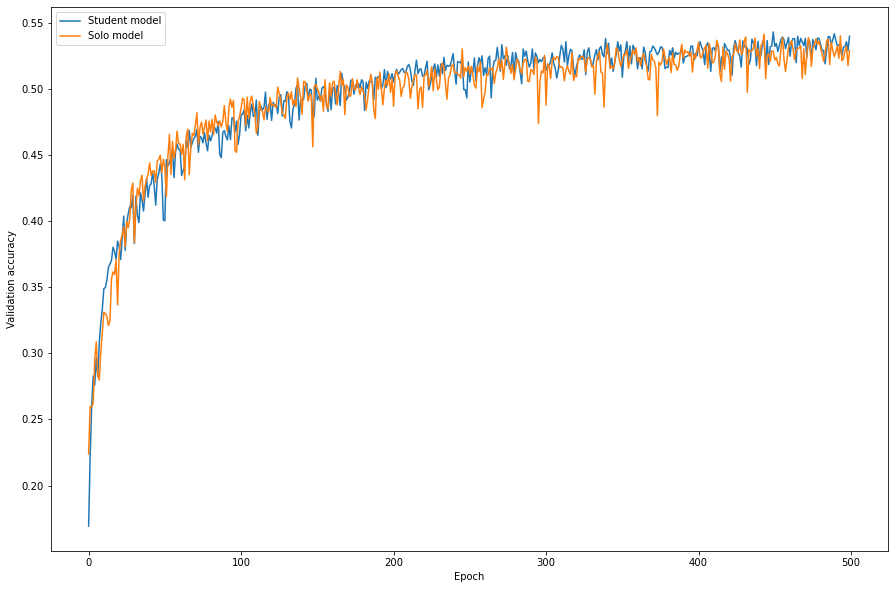

In [50]:
import matplotlib.pyplot as plt

axis_x = np.arange(0, 500)

plt.figure(figsize=(15, 10))
plt.plot(axis_x, student_hist, label='Student model')
plt.plot(axis_x, solo_hist, label='Solo model')
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.legend()
plt.show()

Теперь посмотрим, как покажут себя две модели на тестовых данных

In [99]:
def test(model, dataloaders):
    model.eval()
    
    mistakes = 0
    total = 0
    correct = 0

    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        with torch.no_grad():
            preds = model(inputs).to('cpu')
            _, predicted = torch.max(preds.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            mistakes += (predicted != labels).sum().item()
    
    return 100 * correct / total, mistakes, total

Соло-модель:

In [101]:
solo_acc, solo_mistakes, total = test(best_student_solo, dataloaders_dict)
print('Accuracy: ', solo_acc)
print('Mistakes: ', solo_mistakes, ' out of ', total)

Accuracy:  51.228070175438596
Mistakes:  139  out of  285


Модель-ученик:

In [102]:
student_acc, student_mistakes, total = test(best_student, dataloaders_dict)
print('Accuracy: ', student_acc)
print('Mistakes: ', student_mistakes, ' out of ', total)

Accuracy:  56.14035087719298
Mistakes:  125  out of  285


Я получил результат, схожий с полученным в оригинальной статье Hinton et al, пусть и не такой впечатляющий. Точнее, мне удалось повысить обобщаемость модели-ученика путем передачи ей dark knowledge от модели-учителя. 

### Гиперпараметры

В предыдущих экспериментах я использовал значения $T=10$  и  $\alpha=0.1$ (доля обычного CrossEntropyLoss'a). 
Посмотрим, как изменится результат в зависимости от изменения этих параметров.

Для сокращения времени эксперимента я сокращу количество эпох до 100.

In [104]:
T_params = [2, 4, 8, 10, 16, 20]
alpha_params = [0.1, 0.3, 0.5]

In [120]:
accuracies = np.zeros((6, 3))
mistakes = np.zeros((6, 3))

val_acc_histories = []

for i in range(6):
    for j in range(3):
        student = StudentNetwork()
        student = student.to(device)

        optimizer = Ranger(student.parameters(), lr=0.001)
        
        student, student_val_acc_hist = train('student_T' + str(T_params[i]) + '_alpha' + str(alpha_params[j]), 
                                              student, 
                                              dataloaders_dict,
                                              optimizer, 
                                              num_epochs=100,
                                              teacher_model=model_ft,
                                              T=T_params[i],
                                              alpha=alpha_params[j])
        
        val_acc_histories.append(student_val_acc_hist)
        
        cur_model_acc, cur_model_mistakes, total = test(student, dataloaders_dict)
        
        accuracies[i][j] = cur_model_acc
        mistakes[i][j] = cur_model_mistakes

Epoch 0/99
----------
train Loss: 5.0227 Acc: 0.1575
val Loss: 5.6698 Acc: 0.2261

Epoch 1/99
----------
train Loss: 4.7400 Acc: 0.2053
val Loss: 5.4545 Acc: 0.2429

Epoch 2/99
----------
train Loss: 4.6106 Acc: 0.2234
val Loss: 5.3519 Acc: 0.2662

Epoch 3/99
----------
train Loss: 4.5448 Acc: 0.2461
val Loss: 5.2712 Acc: 0.2766

Epoch 4/99
----------
train Loss: 4.4551 Acc: 0.2540
val Loss: 5.2308 Acc: 0.2859

Epoch 5/99
----------
train Loss: 4.4033 Acc: 0.2643
val Loss: 5.0495 Acc: 0.3101

Epoch 6/99
----------
train Loss: 4.3160 Acc: 0.2803
val Loss: 5.1204 Acc: 0.3131

Epoch 7/99
----------
train Loss: 4.2947 Acc: 0.2862
val Loss: 4.9621 Acc: 0.3252

Epoch 8/99
----------
train Loss: 4.2479 Acc: 0.2932
val Loss: 4.8927 Acc: 0.3359

Epoch 9/99
----------
train Loss: 4.2063 Acc: 0.2909
val Loss: 4.9127 Acc: 0.3378

Epoch 10/99
----------
train Loss: 4.1874 Acc: 0.3035
val Loss: 4.8054 Acc: 0.3480

Epoch 11/99
----------
train Loss: 4.1291 Acc: 0.3115
val Loss: 4.7704 Acc: 0.3515

Ep

train Loss: 3.0638 Acc: 0.4635
val Loss: 3.6536 Acc: 0.4937

Epoch 99/99
----------
train Loss: 3.0264 Acc: 0.4731
val Loss: 3.7086 Acc: 0.4780

Training complete in 42m 52s
Best val Acc: 0.498079
Epoch 0/99
----------
train Loss: 4.4360 Acc: 0.1442
val Loss: 5.0080 Acc: 0.2047

Epoch 1/99
----------
train Loss: 4.1637 Acc: 0.2075
val Loss: 4.7491 Acc: 0.2344

Epoch 2/99
----------
train Loss: 4.0586 Acc: 0.2315
val Loss: 4.5712 Acc: 0.2769

Epoch 3/99
----------
train Loss: 3.9917 Acc: 0.2473
val Loss: 4.5396 Acc: 0.2821

Epoch 4/99
----------
train Loss: 3.9287 Acc: 0.2451
val Loss: 4.4437 Acc: 0.3043

Epoch 5/99
----------
train Loss: 3.8678 Acc: 0.2645
val Loss: 4.4060 Acc: 0.3134

Epoch 6/99
----------
train Loss: 3.8387 Acc: 0.2687
val Loss: 4.3044 Acc: 0.3200

Epoch 7/99
----------
train Loss: 3.7958 Acc: 0.2729
val Loss: 4.2507 Acc: 0.3414

Epoch 8/99
----------
train Loss: 3.7628 Acc: 0.2881
val Loss: 4.2649 Acc: 0.3197

Epoch 9/99
----------
train Loss: 3.7613 Acc: 0.2913
val

val Loss: 3.1517 Acc: 0.5022

Epoch 96/99
----------
train Loss: 2.6870 Acc: 0.4718
val Loss: 3.2088 Acc: 0.4871

Epoch 97/99
----------
train Loss: 2.6710 Acc: 0.4822
val Loss: 3.1762 Acc: 0.5019

Epoch 98/99
----------
train Loss: 2.6812 Acc: 0.4766
val Loss: 3.1626 Acc: 0.4951

Epoch 99/99
----------
train Loss: 2.6791 Acc: 0.4749
val Loss: 3.2279 Acc: 0.4835

Training complete in 43m 40s
Best val Acc: 0.502195
Epoch 0/99
----------
train Loss: 3.8112 Acc: 0.1408
val Loss: 4.2332 Acc: 0.1918

Epoch 1/99
----------
train Loss: 3.6400 Acc: 0.1926
val Loss: 4.0077 Acc: 0.2440

Epoch 2/99
----------
train Loss: 3.5291 Acc: 0.2212
val Loss: 3.9046 Acc: 0.2610

Epoch 3/99
----------
train Loss: 3.5316 Acc: 0.2246
val Loss: 3.8593 Acc: 0.2873

Epoch 4/99
----------
train Loss: 3.4439 Acc: 0.2444
val Loss: 3.8082 Acc: 0.2928

Epoch 5/99
----------
train Loss: 3.4170 Acc: 0.2531
val Loss: 3.7546 Acc: 0.3117

Epoch 6/99
----------
train Loss: 3.3991 Acc: 0.2556
val Loss: 3.7272 Acc: 0.2964

E

train Loss: 2.3621 Acc: 0.4698
val Loss: 2.7001 Acc: 0.5041

Epoch 94/99
----------
train Loss: 2.3829 Acc: 0.4778
val Loss: 2.7164 Acc: 0.4945

Epoch 95/99
----------
train Loss: 2.3932 Acc: 0.4667
val Loss: 2.7069 Acc: 0.4940

Epoch 96/99
----------
train Loss: 2.3772 Acc: 0.4729
val Loss: 2.7119 Acc: 0.5019

Epoch 97/99
----------
train Loss: 2.3775 Acc: 0.4715
val Loss: 2.7620 Acc: 0.4811

Epoch 98/99
----------
train Loss: 2.3658 Acc: 0.4806
val Loss: 2.8563 Acc: 0.4695

Epoch 99/99
----------
train Loss: 2.3610 Acc: 0.4772
val Loss: 2.7170 Acc: 0.5005

Training complete in 41m 57s
Best val Acc: 0.504116
Epoch 0/99
----------
train Loss: 7.5769 Acc: 0.1260
val Loss: 9.3653 Acc: 0.1636

Epoch 1/99
----------
train Loss: 7.0463 Acc: 0.1789
val Loss: 8.7197 Acc: 0.2431

Epoch 2/99
----------
train Loss: 6.8232 Acc: 0.2142
val Loss: 8.4473 Acc: 0.2632

Epoch 3/99
----------
train Loss: 6.7101 Acc: 0.2308
val Loss: 8.3045 Acc: 0.2895

Epoch 4/99
----------
train Loss: 6.5962 Acc: 0.253

val Loss: 5.8615 Acc: 0.4844

Epoch 91/99
----------
train Loss: 4.5794 Acc: 0.4540
val Loss: 5.8603 Acc: 0.4833

Epoch 92/99
----------
train Loss: 4.5746 Acc: 0.4537
val Loss: 5.9497 Acc: 0.4679

Epoch 93/99
----------
train Loss: 4.5914 Acc: 0.4437
val Loss: 5.9232 Acc: 0.4830

Epoch 94/99
----------
train Loss: 4.5331 Acc: 0.4531
val Loss: 5.8071 Acc: 0.4797

Epoch 95/99
----------
train Loss: 4.5822 Acc: 0.4485
val Loss: 5.8192 Acc: 0.4813

Epoch 96/99
----------
train Loss: 4.5085 Acc: 0.4504
val Loss: 5.8878 Acc: 0.4739

Epoch 97/99
----------
train Loss: 4.5517 Acc: 0.4523
val Loss: 5.7713 Acc: 0.4890

Epoch 98/99
----------
train Loss: 4.4873 Acc: 0.4587
val Loss: 5.9428 Acc: 0.4816

Epoch 99/99
----------
train Loss: 4.5202 Acc: 0.4553
val Loss: 5.7942 Acc: 0.4915

Training complete in 41m 56s
Best val Acc: 0.491493
Epoch 0/99
----------
train Loss: 6.3914 Acc: 0.1476
val Loss: 7.6369 Acc: 0.2042

Epoch 1/99
----------
train Loss: 5.9266 Acc: 0.2027
val Loss: 7.3342 Acc: 0.22

train Loss: 3.7632 Acc: 0.4756
val Loss: 4.6343 Acc: 0.5167

Epoch 89/99
----------
train Loss: 3.7493 Acc: 0.4759
val Loss: 4.6842 Acc: 0.5096

Epoch 90/99
----------
train Loss: 3.7216 Acc: 0.4739
val Loss: 4.7447 Acc: 0.4981

Epoch 91/99
----------
train Loss: 3.6969 Acc: 0.4860
val Loss: 4.6401 Acc: 0.5113

Epoch 92/99
----------
train Loss: 3.7743 Acc: 0.4688
val Loss: 4.7408 Acc: 0.4942

Epoch 93/99
----------
train Loss: 3.7444 Acc: 0.4694
val Loss: 4.7469 Acc: 0.4953

Epoch 94/99
----------
train Loss: 3.7327 Acc: 0.4797
val Loss: 4.6977 Acc: 0.5058

Epoch 95/99
----------
train Loss: 3.7220 Acc: 0.4747
val Loss: 4.6172 Acc: 0.5162

Epoch 96/99
----------
train Loss: 3.6739 Acc: 0.4866
val Loss: 4.7522 Acc: 0.4923

Epoch 97/99
----------
train Loss: 3.7329 Acc: 0.4726
val Loss: 4.7951 Acc: 0.4951

Epoch 98/99
----------
train Loss: 3.6511 Acc: 0.4792
val Loss: 4.6532 Acc: 0.5047

Epoch 99/99
----------
train Loss: 3.6993 Acc: 0.4766
val Loss: 4.6930 Acc: 0.5019

Training comple

val Loss: 4.2249 Acc: 0.4690

Epoch 86/99
----------
train Loss: 3.3726 Acc: 0.4514
val Loss: 4.0458 Acc: 0.4775

Epoch 87/99
----------
train Loss: 3.3503 Acc: 0.4390
val Loss: 4.2107 Acc: 0.4583

Epoch 88/99
----------
train Loss: 3.3481 Acc: 0.4544
val Loss: 4.0084 Acc: 0.4923

Epoch 89/99
----------
train Loss: 3.3501 Acc: 0.4521
val Loss: 3.9893 Acc: 0.4931

Epoch 90/99
----------
train Loss: 3.3897 Acc: 0.4419
val Loss: 4.1567 Acc: 0.4698

Epoch 91/99
----------
train Loss: 3.4014 Acc: 0.4389
val Loss: 4.2238 Acc: 0.4673

Epoch 92/99
----------
train Loss: 3.3223 Acc: 0.4517
val Loss: 4.0570 Acc: 0.4734

Epoch 93/99
----------
train Loss: 3.3227 Acc: 0.4533
val Loss: 4.1126 Acc: 0.4745

Epoch 94/99
----------
train Loss: 3.2989 Acc: 0.4585
val Loss: 4.0732 Acc: 0.4846

Epoch 95/99
----------
train Loss: 3.3139 Acc: 0.4526
val Loss: 3.9957 Acc: 0.4951

Epoch 96/99
----------
train Loss: 3.3131 Acc: 0.4521
val Loss: 4.0601 Acc: 0.4816

Epoch 97/99
----------
train Loss: 3.2771 Acc:

train Loss: 4.1453 Acc: 0.4507
val Loss: 5.2828 Acc: 0.4920

Epoch 84/99
----------
train Loss: 4.1096 Acc: 0.4555
val Loss: 5.2515 Acc: 0.4879

Epoch 85/99
----------
train Loss: 4.2004 Acc: 0.4464
val Loss: 5.5273 Acc: 0.4739

Epoch 86/99
----------
train Loss: 4.1327 Acc: 0.4495
val Loss: 5.2671 Acc: 0.4833

Epoch 87/99
----------
train Loss: 4.0453 Acc: 0.4578
val Loss: 5.2927 Acc: 0.4857

Epoch 88/99
----------
train Loss: 4.0960 Acc: 0.4551
val Loss: 5.2465 Acc: 0.4901

Epoch 89/99
----------
train Loss: 4.0616 Acc: 0.4498
val Loss: 5.2687 Acc: 0.4877

Epoch 90/99
----------
train Loss: 4.0936 Acc: 0.4543
val Loss: 5.2255 Acc: 0.4909

Epoch 91/99
----------
train Loss: 4.1021 Acc: 0.4595
val Loss: 5.2390 Acc: 0.4835

Epoch 92/99
----------
train Loss: 4.0469 Acc: 0.4585
val Loss: 5.2058 Acc: 0.4852

Epoch 93/99
----------
train Loss: 4.0601 Acc: 0.4591
val Loss: 5.3461 Acc: 0.4877

Epoch 94/99
----------
train Loss: 4.0568 Acc: 0.4584
val Loss: 5.1944 Acc: 0.4868

Epoch 95/99
---

val Loss: 4.5274 Acc: 0.4918

Epoch 81/99
----------
train Loss: 3.6362 Acc: 0.4496
val Loss: 4.5598 Acc: 0.4852

Epoch 82/99
----------
train Loss: 3.5845 Acc: 0.4657
val Loss: 4.4573 Acc: 0.4962

Epoch 83/99
----------
train Loss: 3.6495 Acc: 0.4511
val Loss: 4.4863 Acc: 0.4929

Epoch 84/99
----------
train Loss: 3.5962 Acc: 0.4594
val Loss: 4.6076 Acc: 0.4852

Epoch 85/99
----------
train Loss: 3.5837 Acc: 0.4629
val Loss: 4.4941 Acc: 0.4929

Epoch 86/99
----------
train Loss: 3.5505 Acc: 0.4627
val Loss: 4.4753 Acc: 0.4866

Epoch 87/99
----------
train Loss: 3.5609 Acc: 0.4650
val Loss: 4.4059 Acc: 0.4986

Epoch 88/99
----------
train Loss: 3.5189 Acc: 0.4639
val Loss: 4.4245 Acc: 0.4951

Epoch 89/99
----------
train Loss: 3.5150 Acc: 0.4643
val Loss: 4.3880 Acc: 0.5014

Epoch 90/99
----------
train Loss: 3.5029 Acc: 0.4688
val Loss: 4.4463 Acc: 0.4948

Epoch 91/99
----------
train Loss: 3.5256 Acc: 0.4676
val Loss: 4.5321 Acc: 0.4992

Epoch 92/99
----------
train Loss: 3.5172 Acc:

train Loss: 3.1406 Acc: 0.4480
val Loss: 3.8182 Acc: 0.4844

Epoch 79/99
----------
train Loss: 3.1277 Acc: 0.4564
val Loss: 3.7416 Acc: 0.4934

Epoch 80/99
----------
train Loss: 3.0707 Acc: 0.4644
val Loss: 3.7978 Acc: 0.4833

Epoch 81/99
----------
train Loss: 3.0835 Acc: 0.4546
val Loss: 3.7421 Acc: 0.4871

Epoch 82/99
----------
train Loss: 3.1156 Acc: 0.4562
val Loss: 3.7072 Acc: 0.4918

Epoch 83/99
----------
train Loss: 3.1173 Acc: 0.4540
val Loss: 3.7501 Acc: 0.4909

Epoch 84/99
----------
train Loss: 3.0726 Acc: 0.4622
val Loss: 3.7384 Acc: 0.4846

Epoch 85/99
----------
train Loss: 3.0803 Acc: 0.4634
val Loss: 3.6976 Acc: 0.4964

Epoch 86/99
----------
train Loss: 3.0505 Acc: 0.4591
val Loss: 3.7202 Acc: 0.4896

Epoch 87/99
----------
train Loss: 3.0931 Acc: 0.4624
val Loss: 3.6708 Acc: 0.5033

Epoch 88/99
----------
train Loss: 3.0299 Acc: 0.4632
val Loss: 3.7320 Acc: 0.4838

Epoch 89/99
----------
train Loss: 3.0426 Acc: 0.4625
val Loss: 3.6671 Acc: 0.4992

Epoch 90/99
---

val Loss: 5.1336 Acc: 0.4698

Epoch 76/99
----------
train Loss: 4.0934 Acc: 0.4235
val Loss: 5.1682 Acc: 0.4759

Epoch 77/99
----------
train Loss: 4.1604 Acc: 0.4245
val Loss: 5.1263 Acc: 0.4684

Epoch 78/99
----------
train Loss: 4.1560 Acc: 0.4308
val Loss: 5.2196 Acc: 0.4706

Epoch 79/99
----------
train Loss: 4.1523 Acc: 0.4240
val Loss: 5.1855 Acc: 0.4687

Epoch 80/99
----------
train Loss: 4.1290 Acc: 0.4256
val Loss: 5.2179 Acc: 0.4679

Epoch 81/99
----------
train Loss: 4.1836 Acc: 0.4287
val Loss: 5.1657 Acc: 0.4720

Epoch 82/99
----------
train Loss: 4.1075 Acc: 0.4253
val Loss: 5.2539 Acc: 0.4662

Epoch 83/99
----------
train Loss: 4.1176 Acc: 0.4265
val Loss: 5.1432 Acc: 0.4695

Epoch 84/99
----------
train Loss: 4.1008 Acc: 0.4317
val Loss: 5.1703 Acc: 0.4657

Epoch 85/99
----------
train Loss: 4.1298 Acc: 0.4306
val Loss: 5.0772 Acc: 0.4726

Epoch 86/99
----------
train Loss: 4.0397 Acc: 0.4336
val Loss: 5.1328 Acc: 0.4706

Epoch 87/99
----------
train Loss: 4.0811 Acc:

train Loss: 3.7277 Acc: 0.4151
val Loss: 4.7906 Acc: 0.4193

Epoch 74/99
----------
train Loss: 3.7046 Acc: 0.4194
val Loss: 4.5521 Acc: 0.4512

Epoch 75/99
----------
train Loss: 3.6900 Acc: 0.4197
val Loss: 4.6435 Acc: 0.4388

Epoch 76/99
----------
train Loss: 3.6659 Acc: 0.4291
val Loss: 4.4860 Acc: 0.4753

Epoch 77/99
----------
train Loss: 3.6698 Acc: 0.4266
val Loss: 4.4992 Acc: 0.4717

Epoch 78/99
----------
train Loss: 3.6659 Acc: 0.4222
val Loss: 4.5902 Acc: 0.4690

Epoch 79/99
----------
train Loss: 3.6998 Acc: 0.4230
val Loss: 4.6704 Acc: 0.4421

Epoch 80/99
----------
train Loss: 3.6555 Acc: 0.4270
val Loss: 4.4675 Acc: 0.4649

Epoch 81/99
----------
train Loss: 3.6645 Acc: 0.4302
val Loss: 4.5036 Acc: 0.4660

Epoch 82/99
----------
train Loss: 3.6225 Acc: 0.4312
val Loss: 4.5428 Acc: 0.4484

Epoch 83/99
----------
train Loss: 3.6481 Acc: 0.4237
val Loss: 4.4163 Acc: 0.4811

Epoch 84/99
----------
train Loss: 3.6221 Acc: 0.4331
val Loss: 4.4816 Acc: 0.4739

Epoch 85/99
---

val Loss: 3.5696 Acc: 0.4846

Epoch 71/99
----------
train Loss: 3.0482 Acc: 0.4367
val Loss: 3.5301 Acc: 0.4879

Epoch 72/99
----------
train Loss: 3.0272 Acc: 0.4435
val Loss: 3.5347 Acc: 0.4926

Epoch 73/99
----------
train Loss: 3.0271 Acc: 0.4356
val Loss: 3.5701 Acc: 0.4844

Epoch 74/99
----------
train Loss: 3.0064 Acc: 0.4432
val Loss: 3.7031 Acc: 0.4830

Epoch 75/99
----------
train Loss: 3.0030 Acc: 0.4498
val Loss: 3.5589 Acc: 0.4898

Epoch 76/99
----------
train Loss: 3.0185 Acc: 0.4482
val Loss: 3.5136 Acc: 0.4984

Epoch 77/99
----------
train Loss: 3.0037 Acc: 0.4516
val Loss: 3.5158 Acc: 0.4937

Epoch 78/99
----------
train Loss: 2.9701 Acc: 0.4551
val Loss: 3.5107 Acc: 0.4929

Epoch 79/99
----------
train Loss: 2.9878 Acc: 0.4441
val Loss: 3.5286 Acc: 0.4926

Epoch 80/99
----------
train Loss: 2.9524 Acc: 0.4638
val Loss: 3.4825 Acc: 0.4931

Epoch 81/99
----------
train Loss: 2.9620 Acc: 0.4530
val Loss: 3.5370 Acc: 0.4926

Epoch 82/99
----------
train Loss: 2.9473 Acc:

train Loss: 3.8343 Acc: 0.4140
val Loss: 4.7038 Acc: 0.4682

Epoch 69/99
----------
train Loss: 3.7361 Acc: 0.4263
val Loss: 4.7921 Acc: 0.4728

Epoch 70/99
----------
train Loss: 3.7612 Acc: 0.4238
val Loss: 4.6875 Acc: 0.4684

Epoch 71/99
----------
train Loss: 3.7987 Acc: 0.4226
val Loss: 4.6558 Acc: 0.4726

Epoch 72/99
----------
train Loss: 3.8222 Acc: 0.4276
val Loss: 4.7951 Acc: 0.4418

Epoch 73/99
----------
train Loss: 3.7884 Acc: 0.4269
val Loss: 4.6674 Acc: 0.4693

Epoch 74/99
----------
train Loss: 3.7858 Acc: 0.4263
val Loss: 4.7227 Acc: 0.4597

Epoch 75/99
----------
train Loss: 3.7528 Acc: 0.4238
val Loss: 4.6826 Acc: 0.4673

Epoch 76/99
----------
train Loss: 3.7272 Acc: 0.4214
val Loss: 4.6190 Acc: 0.4739

Epoch 77/99
----------
train Loss: 3.7477 Acc: 0.4295
val Loss: 4.6060 Acc: 0.4695

Epoch 78/99
----------
train Loss: 3.7470 Acc: 0.4263
val Loss: 4.6156 Acc: 0.4632

Epoch 79/99
----------
train Loss: 3.7311 Acc: 0.4268
val Loss: 4.6070 Acc: 0.4731

Epoch 80/99
---

val Loss: 3.9915 Acc: 0.4791

Epoch 66/99
----------
train Loss: 3.3613 Acc: 0.4293
val Loss: 4.1453 Acc: 0.4597

Epoch 67/99
----------
train Loss: 3.3640 Acc: 0.4327
val Loss: 4.0893 Acc: 0.4536

Epoch 68/99
----------
train Loss: 3.3377 Acc: 0.4283
val Loss: 4.0536 Acc: 0.4643

Epoch 69/99
----------
train Loss: 3.2878 Acc: 0.4351
val Loss: 3.9983 Acc: 0.4668

Epoch 70/99
----------
train Loss: 3.3208 Acc: 0.4351
val Loss: 3.9420 Acc: 0.4761

Epoch 71/99
----------
train Loss: 3.3287 Acc: 0.4311
val Loss: 3.9695 Acc: 0.4849

Epoch 72/99
----------
train Loss: 3.2981 Acc: 0.4372
val Loss: 3.9840 Acc: 0.4739

Epoch 73/99
----------
train Loss: 3.2947 Acc: 0.4350
val Loss: 4.0299 Acc: 0.4706

Epoch 74/99
----------
train Loss: 3.2544 Acc: 0.4404
val Loss: 4.0216 Acc: 0.4734

Epoch 75/99
----------
train Loss: 3.2475 Acc: 0.4408
val Loss: 3.9547 Acc: 0.4915

Epoch 76/99
----------
train Loss: 3.2786 Acc: 0.4459
val Loss: 3.9756 Acc: 0.4838

Epoch 77/99
----------
train Loss: 3.2541 Acc:

train Loss: 2.9359 Acc: 0.4267
val Loss: 3.5025 Acc: 0.4550

Epoch 64/99
----------
train Loss: 2.9363 Acc: 0.4263
val Loss: 3.3999 Acc: 0.4715

Epoch 65/99
----------
train Loss: 2.9633 Acc: 0.4230
val Loss: 3.3592 Acc: 0.4717

Epoch 66/99
----------
train Loss: 2.9345 Acc: 0.4212
val Loss: 3.3829 Acc: 0.4632

Epoch 67/99
----------
train Loss: 2.9040 Acc: 0.4254
val Loss: 3.3659 Acc: 0.4641

Epoch 68/99
----------
train Loss: 2.9246 Acc: 0.4267
val Loss: 3.3499 Acc: 0.4783

Epoch 69/99
----------
train Loss: 2.9051 Acc: 0.4301
val Loss: 3.4450 Acc: 0.4660

Epoch 70/99
----------
train Loss: 2.9128 Acc: 0.4371
val Loss: 3.3537 Acc: 0.4717

Epoch 71/99
----------
train Loss: 2.8957 Acc: 0.4332
val Loss: 3.3377 Acc: 0.4824

Epoch 72/99
----------
train Loss: 2.8965 Acc: 0.4331
val Loss: 3.3935 Acc: 0.4591

Epoch 73/99
----------
train Loss: 2.8958 Acc: 0.4297
val Loss: 3.3590 Acc: 0.4745

Epoch 74/99
----------
train Loss: 2.8796 Acc: 0.4336
val Loss: 3.3336 Acc: 0.4783

Epoch 75/99
---

val Loss: 4.5945 Acc: 0.4597

Epoch 61/99
----------
train Loss: 3.7019 Acc: 0.4199
val Loss: 4.5525 Acc: 0.4536

Epoch 62/99
----------
train Loss: 3.6880 Acc: 0.4226
val Loss: 4.6558 Acc: 0.4415

Epoch 63/99
----------
train Loss: 3.7365 Acc: 0.4175
val Loss: 4.6770 Acc: 0.4446

Epoch 64/99
----------
train Loss: 3.7177 Acc: 0.4088
val Loss: 4.5158 Acc: 0.4490

Epoch 65/99
----------
train Loss: 3.6501 Acc: 0.4184
val Loss: 4.4737 Acc: 0.4662

Epoch 66/99
----------
train Loss: 3.6470 Acc: 0.4220
val Loss: 4.5549 Acc: 0.4539

Epoch 67/99
----------
train Loss: 3.6658 Acc: 0.4309
val Loss: 4.5392 Acc: 0.4624

Epoch 68/99
----------
train Loss: 3.6698 Acc: 0.4205
val Loss: 4.5142 Acc: 0.4608

Epoch 69/99
----------
train Loss: 3.6137 Acc: 0.4318
val Loss: 4.5127 Acc: 0.4679

Epoch 70/99
----------
train Loss: 3.6422 Acc: 0.4327
val Loss: 4.5091 Acc: 0.4662

Epoch 71/99
----------
train Loss: 3.6336 Acc: 0.4266
val Loss: 4.3837 Acc: 0.4756

Epoch 72/99
----------
train Loss: 3.6012 Acc:

train Loss: 3.3067 Acc: 0.4133
val Loss: 3.9285 Acc: 0.4775

Epoch 59/99
----------
train Loss: 3.2867 Acc: 0.4248
val Loss: 3.9111 Acc: 0.4794

Epoch 60/99
----------
train Loss: 3.2941 Acc: 0.4263
val Loss: 4.0113 Acc: 0.4575

Epoch 61/99
----------
train Loss: 3.2982 Acc: 0.4234
val Loss: 3.9138 Acc: 0.4728

Epoch 62/99
----------
train Loss: 3.2415 Acc: 0.4264
val Loss: 3.9382 Acc: 0.4750

Epoch 63/99
----------
train Loss: 3.2776 Acc: 0.4279
val Loss: 3.8521 Acc: 0.4775

Epoch 64/99
----------
train Loss: 3.2307 Acc: 0.4337
val Loss: 3.8908 Acc: 0.4759

Epoch 65/99
----------
train Loss: 3.2467 Acc: 0.4279
val Loss: 3.8137 Acc: 0.4841

Epoch 66/99
----------
train Loss: 3.2064 Acc: 0.4339
val Loss: 3.8703 Acc: 0.4808

Epoch 67/99
----------
train Loss: 3.2169 Acc: 0.4318
val Loss: 3.8605 Acc: 0.4846

Epoch 68/99
----------
train Loss: 3.2201 Acc: 0.4366
val Loss: 3.8161 Acc: 0.4844

Epoch 69/99
----------
train Loss: 3.1795 Acc: 0.4350
val Loss: 3.9218 Acc: 0.4715

Epoch 70/99
---

val Loss: 3.4749 Acc: 0.4523

Epoch 56/99
----------
train Loss: 2.9124 Acc: 0.4209
val Loss: 3.4210 Acc: 0.4577

Epoch 57/99
----------
train Loss: 2.9123 Acc: 0.4192
val Loss: 3.4040 Acc: 0.4627

Epoch 58/99
----------
train Loss: 2.8978 Acc: 0.4235
val Loss: 3.3630 Acc: 0.4676

Epoch 59/99
----------
train Loss: 2.9224 Acc: 0.4224
val Loss: 3.3450 Acc: 0.4764

Epoch 60/99
----------
train Loss: 2.8713 Acc: 0.4228
val Loss: 3.4075 Acc: 0.4660

Epoch 61/99
----------
train Loss: 2.8995 Acc: 0.4215
val Loss: 3.3632 Acc: 0.4698

Epoch 62/99
----------
train Loss: 2.8926 Acc: 0.4240
val Loss: 3.3333 Acc: 0.4750

Epoch 63/99
----------
train Loss: 2.8691 Acc: 0.4319
val Loss: 3.3986 Acc: 0.4638

Epoch 64/99
----------
train Loss: 2.8451 Acc: 0.4338
val Loss: 3.3294 Acc: 0.4737

Epoch 65/99
----------
train Loss: 2.8694 Acc: 0.4283
val Loss: 3.2875 Acc: 0.4868

Epoch 66/99
----------
train Loss: 2.8387 Acc: 0.4286
val Loss: 3.3554 Acc: 0.4643

Epoch 67/99
----------
train Loss: 2.8615 Acc:

Посмотрим на результаты эксперимента

In [166]:
import seaborn as sns

[Text(373.36363636363626, 0.5, 'T'),
 Text(0.5, 15.0, 'alpha'),
 Text(0.5, 1.0, 'Number of mistakes w.r.t.')]

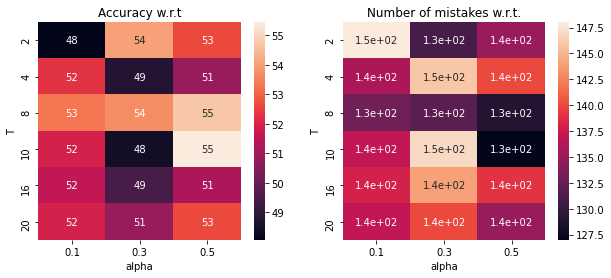

In [204]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
acc_map = sns.heatmap(accuracies,
                      ax=ax[0],
                      annot=True, 
                      xticklabels=alpha_params, 
                      yticklabels=T_params)
acc_map.set(title='Accuracy w.r.t', xlabel='alpha', ylabel='T')

mistakes_map = sns.heatmap(mistakes,
                      ax=ax[1],
                      annot=True, 
                      xticklabels=alpha_params, 
                      yticklabels=T_params)
mistakes_map.set(title='Number of mistakes w.r.t.', xlabel='alpha', ylabel='T')

Из результатов эксперимента видно, что наилучший результат достигается при 'среднем' значении $T=10$ и параметре $\alpha=0.5$, то есть когда лосс с ground truth labels и предсказаниями модели-учителя учитываются с равными весами. 

Подбор параметров $T$ и $\alpha$ позволил за 100 эпох достичь улучшения на $4\%$ по сравнению с моделью, обучавшейся без помощи учителя. 

In [206]:
solo_net100 = StudentNetwork()
solo_net100 = solo_net100.to(device)

optim_solo100 = Ranger(solo_net100.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

solo_net100, _ = train_solo('solo_100', solo_net100, dataloaders_dict, criterion, optim_solo100, num_epochs=100)

solo100_acc, solo_acc_mistakes, total = test(solo_net100, dataloaders_dict)
print(solo100_acc)

Epoch 0/99
----------
train Loss: 2.2451 Acc: 0.1541
val Loss: 2.1179 Acc: 0.2311

Epoch 1/99
----------
train Loss: 2.1391 Acc: 0.2103
val Loss: 2.0500 Acc: 0.2591

Epoch 2/99
----------
train Loss: 2.0942 Acc: 0.2384
val Loss: 2.0193 Acc: 0.2747

Epoch 3/99
----------
train Loss: 2.0713 Acc: 0.2468
val Loss: 1.9947 Acc: 0.2807

Epoch 4/99
----------
train Loss: 2.0527 Acc: 0.2539
val Loss: 1.9430 Acc: 0.3054

Epoch 5/99
----------
train Loss: 2.0353 Acc: 0.2626
val Loss: 1.9192 Acc: 0.3252

Epoch 6/99
----------
train Loss: 2.0271 Acc: 0.2718
val Loss: 1.9104 Acc: 0.3145

Epoch 7/99
----------
train Loss: 2.0186 Acc: 0.2736
val Loss: 1.9066 Acc: 0.3279

Epoch 8/99
----------
train Loss: 1.9920 Acc: 0.2900
val Loss: 1.8735 Acc: 0.3340

Epoch 9/99
----------
train Loss: 1.9733 Acc: 0.2922
val Loss: 1.8877 Acc: 0.3460

Epoch 10/99
----------
train Loss: 1.9630 Acc: 0.2915
val Loss: 1.8382 Acc: 0.3570

Epoch 11/99
----------
train Loss: 1.9433 Acc: 0.3091
val Loss: 1.8159 Acc: 0.3606

Ep

train Loss: 1.5400 Acc: 0.4604
val Loss: 1.5809 Acc: 0.4523

Epoch 99/99
----------
train Loss: 1.5210 Acc: 0.4689
val Loss: 1.6019 Acc: 0.4495

Training complete in 11m 46s
Best val Acc: 0.468990
50.526315789473685


### Итоги

В ходе выполнения этого тестового задания я познакомился с простейшим из методов Knowledge Distillation и экспериментально подтвердил его действенность.

С помощью передачи знаний от большой модели-учителя маленькой модели-ученику мне удалось достичь прироста метрики Accuracy на $4\%$.